In [72]:
""" import useful functions """

# Generic
import pandas as pd
import numpy as np
import scipy
import sys
from itertools import islice, cycle
import math
import os
import sys
from scipy.integrate import odeint
from importlib import reload

# cosmology
import pyccl as ccl
import tjpcov as tjp
from tjpcov.covariance_calculator import CovarianceCalculator
from astropy.io import fits
import yaml
import sacc
import time

import matplotlib.pyplot as plt

"""
# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# MCMC
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
"""
# SRD Binning
import srd_redshift_distributions as srd
import binning


In [80]:
reload(tjp)

<module 'tjpcov' from '/home/c2042999/PCA_env_cov/3.8.10/lib/python3.11/site-packages/tjpcov/__init__.py'>

In [3]:
def cov2corr(cov):
    """
    Convert a covariance matrix into a correlation matrix
    input:
        cov: numpy.array with dim:(N,N)
    returns:
        corr: numpy.array with dim:(N,N)
    """
    sig = np.sqrt(cov.diagonal())
    return cov/np.outer(sig, sig)

# SRD Covariance Matrix

In [4]:
# ell binning for shear
ells_SRD = np.loadtxt("/home/c2042999/PCA_project/ell-values")[:13]

print(ells_SRD.shape)

(13,)


In [5]:
print(np.log10(ells_SRD[1]) - np.log10(ells_SRD[0]))

print(10**(np.log10(ells_SRD) - 0.14375314687886442/2))
print(10**(np.log10(ells_SRD) + 0.14375314687886442/2))
print((ells_SRD))


0.14375314687886442
[  19.999996     27.84729757   38.7735953    53.98699751   75.16959305
  104.66351293  145.72978945  202.90906419  282.52345015  393.37568457
  547.72253099  762.62962666 1061.85904855]
[  27.84729757   38.77360686   53.98700311   75.16961428  104.66352225
  145.72982863  202.9090812   282.52351106  393.37580807  547.72259688
  762.62976796 1061.85892    1478.49554104]
[  23.5997    32.8594    45.75227   63.70386   88.69901  123.5014
  171.959    239.4297   333.3735   464.1775   646.3045   899.8917
 1252.978  ]


In [6]:
"""Get SRD covariance matrix to compare"""

# covariance for shear bin combinations, in order: z11, z12, z13,..., z15, z22, z23,...z55
shear_cl_SRD_old = np.loadtxt("/home/c2042999/PCA_project/cov_shearonly_Gaussian_Y1.txt")

shear_cl_SRD = np.loadtxt("/home/c2042999/PCA_project/cov_shearonly_Gaussian_Y1.txt")

idx = 0
bins_SRD = 20

for j in range(15):
    for i in range(20):
        if i >= 13:
            
            shear_cl_SRD = np.delete(shear_cl_SRD, j*bins_SRD + i - idx, 0)
            shear_cl_SRD = np.delete(shear_cl_SRD, j*bins_SRD + i - idx, 1)

            idx += 1

print(shear_cl_SRD.shape)

(195, 195)


In [7]:
"""matrix_test = np.array([[11,12,13,14,15,16,17,18],[21,22,23,24,25,26,27,28],[31,32,33,34,35,36,37,38] \
                       ,[41,42,43,44,45,46,47,48],[51,52,53,54,55,56,57,58],[61,62,63,64,65,66,67,68]\
                       ,[71,72,73,74,75,76,77,78],[81,82,83,84,85,86,87,88]])
idx = 0
zbins_SRD = 4

for j in range(2):
    for i in range(4):
        if i >= 3:
            print(i,j)
            print(j*zbins_SRD + i - idx)
            matrix_test = np.delete(matrix_test, j*zbins_SRD + i - idx, 0)
            matrix_test = np.delete(matrix_test, j*zbins_SRD + i - idx, 1)
            print(matrix_test)
            idx += 1
"""


'matrix_test = np.array([[11,12,13,14,15,16,17,18],[21,22,23,24,25,26,27,28],[31,32,33,34,35,36,37,38]                        ,[41,42,43,44,45,46,47,48],[51,52,53,54,55,56,57,58],[61,62,63,64,65,66,67,68]                       ,[71,72,73,74,75,76,77,78],[81,82,83,84,85,86,87,88]])\nidx = 0\nzbins_SRD = 4\n\nfor j in range(2):\n    for i in range(4):\n        if i >= 3:\n            print(i,j)\n            print(j*zbins_SRD + i - idx)\n            matrix_test = np.delete(matrix_test, j*zbins_SRD + i - idx, 0)\n            matrix_test = np.delete(matrix_test, j*zbins_SRD + i - idx, 1)\n            print(matrix_test)\n            idx += 1\n'

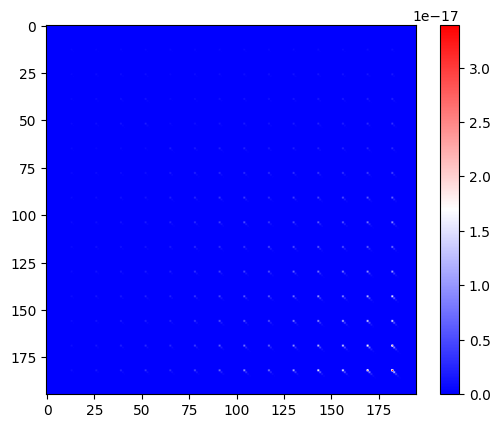

In [8]:
plt.imshow(shear_cl_SRD, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

(195, 195)


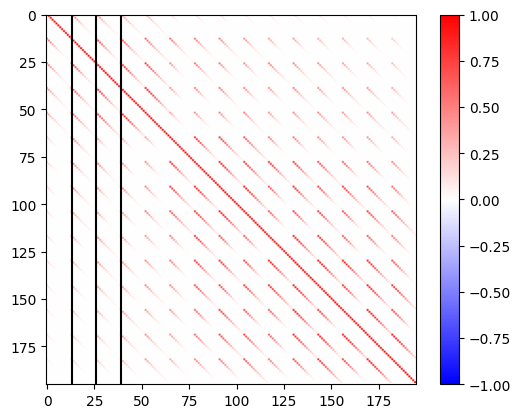

In [9]:
corr_SRD = cov2corr(shear_cl_SRD)
print(corr_SRD.shape)
plt.imshow(corr_SRD, origin='upper', vmin=-1, vmax=1, cmap='bwr')

x = [13, 13] 
y = [0, 195] 
plt.plot(x,y, color="k") 
x = [26,26] 
y = [0, 195] 
plt.plot(x,y, color="k")
x = [39, 39] 
y = [0, 195] 
plt.plot(x,y, color="k") 
plt.ylim(195,0)

plt.colorbar()
plt.show()

# Get covariance matrix myself

## METHOD1: Create mock redshift distribution (define z and output dNdz)

The SRD document says that for Y1 $\alpha = 2$, $z_0 = 0.13$ and $\beta = 0.78$, and a total of 5 source redshift bins.

In [165]:
""" Get a binned redshift distribution - defining functions """
"""This will come from the dataset we decide to test"""

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z):
    """
    Defines a reasonable redshift distribution (not normalized yet)
    input:
        redshift z: numpy.array with dim:N
    returns:
        redshift distribution p(z): numpy.array with dim:N
    """
    alpha = 2
    beta = 0.78
    z0 = 0.13
    pz = z**alpha * np.exp(-(z / z0)**beta)
    return pz

def bindist(z, n_bins):
    """
    Finds redshift bins so that integral of p(z) over each bin stays the same.
    (in limit of large len(z))
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int (value M)
    returns:
        redshift bin edges: numpy.array with dim:M+1
    """
    # have redshiftdist(z), z 
    # find bins: integrate between 0 and i redshift(z)
    #            if integral => 1/n_bin, that is a bin
    #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N                                                             # Normalize p(z)
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

def gaussianphotoz(zs , zp):
    """
    Finds gaussian photo-z uncertainties
    """
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

def binning_redshiftdist(z , n_bins):
    """
    bins distribution for p(z) in n_bins with same number of galaxies in each bin, 
    smoothened by gaussianphotoz(zs , zp) kernel
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int of size M
    returns:
        binned redshift distribution: numpy.array with dim:(N,M)
        sum: p(z) recovered by summing over all binned redshift distributions: numpy.array with dim:N
    """
    N = scipy.integrate.simps(redshiftdist(z), z)

    # complete binning
    bin_edges = bindist(z, n_bins)

    # smoothing redshift distribution with gaussian kernel
    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))
    
    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j])/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [166]:
""" Get a binned redshift distribution - getting the actual distribution """

# find normalized redshift distribution

z = np.linspace(0.001 , 2.5 , 256)

Rdist = redshiftdist(z)
N = scipy.integrate.simps(Rdist, z)                                    # Normalization factor
Rdist = Rdist/N

Binned_distribution = binning_redshiftdist(z , 5)[0]

(5, 256)


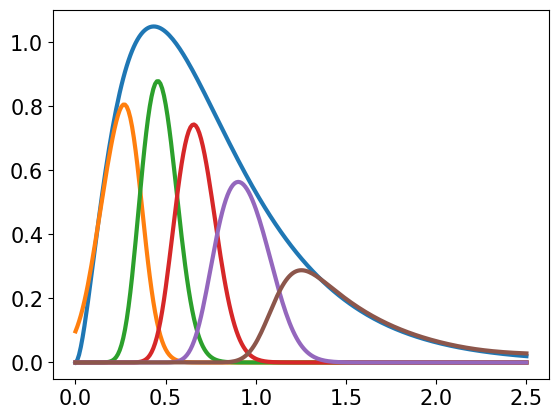

In [194]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[3])
plt.plot(z ,Binned_distribution[len(Binned_distribution)-1])

print(Binned_distribution.shape)

## METHOD2: Get mock redshift distribution from SRD

(5, 500)
(500,)


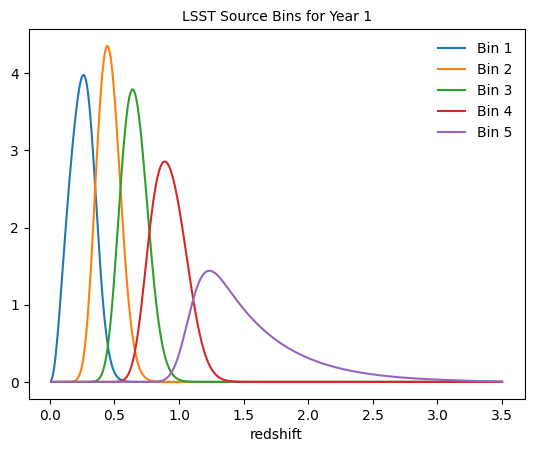

In [10]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.01, 3.5, 500)
forecast_years = ["1", "10"]  # Assuming integers are appropriate

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
# print(redshift_distribution["sources"].keys())


bins = {
    "sources": {},
    "lenses": {}
}

# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = binning.Binning(redshift_range, 
                                            redshift_distribution["sources"][year],
                                            year).source_bins(normalised=True,
                                                              save_file=False)
    bins["lenses"][year] = binning.Binning(redshift_range, 
                                           redshift_distribution["lenses"][year],
                                           year).lens_bins(normalised=True,
                                                           save_file=False)


for bin_idx, (key, data) in enumerate(bins["sources"]["1"].items()):
    plt.plot(redshift_range,
            data, 
            label=f"Bin {key+1}")
    plt.xlabel("redshift")
    plt.title(f"LSST Source Bins for Year 1", fontsize=10)
    plt.legend(frameon=False, ncol=1)

#(5, 256)
Binned_distribution = [list(bins["sources"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution = np.append(Binned_distribution,\
               [list(bins["sources"]["1"].items())[i+1][1]], axis=0)
    
print(Binned_distribution.shape)
print(redshift_range.shape)

(5, 500)


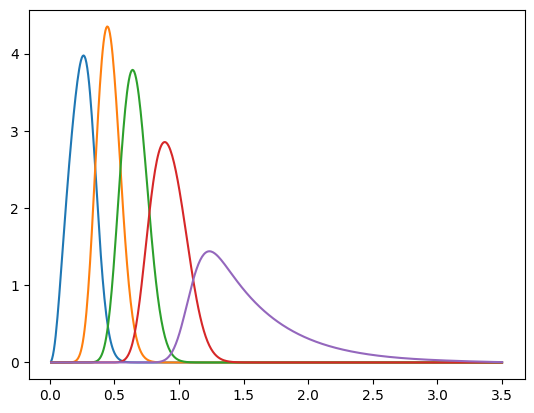

In [11]:
## TEST2: Plots to check binned redshift distribution

z = redshift_range

#plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[3])
plt.plot(z ,Binned_distribution[len(Binned_distribution)-1])

print(Binned_distribution.shape)

## Get covariance from tjpcov

In [71]:
"""Define sacc file - C^{ij}(ell) for some ell bins and redshift bins"""
# My redshifts (for now)
src0 = Binned_distribution[0]
src1 = Binned_distribution[1]
src2 = Binned_distribution[2]
src3 = Binned_distribution[3]
src4 = Binned_distribution[4]
z_src = z

ell_bins = ells_SRD

# Define cosmology -- our "universe cosmology"

cosmo_universe = ccl.Cosmology(Omega_c = 0.26, 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 0.96,
                          A_s = 2.01e-9)

# z binning

src_bins = [src0, src1, src2, src3, src4]

s = sacc.Sacc()

for i, bin1 in enumerate(src_bins):
    shearA = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin1), has_shear=True)
    s.add_tracer('NZ', 'src%d'%i, z=z_src, nz=bin1)
    for j, bin2 in enumerate(src_bins):
        if j > i:
            break
        # construct Cl_gM for sacc file
        shearB = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin2), has_shear=True)

        Cl = ccl.angular_cl(cosmo_universe, shearA, shearB, ell_bins)
        # bin ell
        s.add_ell_cl('galaxy_shear_cl_ee', 'src%d'%i, 
                            'src%d'%j, ell_bins, Cl, tracers_later=False)

s.save_fits('/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits', overwrite=True)

In [77]:
s = sacc.Sacc.load_fits('/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits')
dts = s.get_data_types()
tracer_sets = s.get_tracer_combinations('galaxy_shear_cl_ee')
print("data types ", dts)
print("tracer_sets " , tracer_sets)
print((s.get_ell_cl('galaxy_shear_cl_ee','src1','src1')))

data types  ['galaxy_shear_cl_ee']
tracer_sets  [('src0', 'src0'), ('src1', 'src0'), ('src1', 'src1'), ('src2', 'src0'), ('src2', 'src1'), ('src2', 'src2'), ('src3', 'src0'), ('src3', 'src1'), ('src3', 'src2'), ('src3', 'src3'), ('src4', 'src0'), ('src4', 'src1'), ('src4', 'src2'), ('src4', 'src3'), ('src4', 'src4')]
(array([  23.5997 ,   32.8594 ,   45.75227,   63.70386,   88.69901,
        123.5014 ,  171.959  ,  239.4297 ,  333.3735 ,  464.1775 ,
        646.3045 ,  899.8917 , 1252.978  ]), array([8.84130803e-09, 6.37963713e-09, 4.44248154e-09, 2.96728194e-09,
       1.93424575e-09, 1.26825364e-09, 8.41806136e-10, 5.70974407e-10,
       3.93434407e-10, 2.71407197e-10, 1.83999161e-10, 1.20523792e-10,
       7.53352655e-11]))


In [81]:
config = '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/Fourier_cosmic_shear_gauss.yaml'

gauss_calc = CovarianceCalculator(config)

# get matrix
gauss_cov = gauss_calc.get_covariance()

Computing independent covariance blocks
Rank None: ('src0', 'src0'), ('src0', 'src0')


/home/c2042999/PCA_env_cov/3.8.10/lib/python3.11/site-packages/tjpcov/covariance_builder.py:887: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Rank None: ('src0', 'src0'), ('src1', 'src0')
Rank None: ('src0', 'src0'), ('src1', 'src1')


/home/c2042999/PCA_env_cov/3.8.10/lib/python3.11/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


Rank None: ('src0', 'src0'), ('src2', 'src0')
Rank None: ('src0', 'src0'), ('src2', 'src1')
Rank None: ('src0', 'src0'), ('src2', 'src2')
Rank None: ('src0', 'src0'), ('src3', 'src0')
Rank None: ('src0', 'src0'), ('src3', 'src1')
Rank None: ('src0', 'src0'), ('src3', 'src2')
Rank None: ('src0', 'src0'), ('src3', 'src3')
Rank None: ('src0', 'src0'), ('src4', 'src0')
Rank None: ('src0', 'src0'), ('src4', 'src1')
Rank None: ('src0', 'src0'), ('src4', 'src2')
Rank None: ('src0', 'src0'), ('src4', 'src3')
Rank None: ('src0', 'src0'), ('src4', 'src4')
Rank None: ('src1', 'src0'), ('src1', 'src0')
Rank None: ('src1', 'src0'), ('src1', 'src1')
Rank None: ('src1', 'src0'), ('src2', 'src0')
Rank None: ('src1', 'src0'), ('src2', 'src1')
Rank None: ('src1', 'src0'), ('src2', 'src2')
Rank None: ('src1', 'src0'), ('src3', 'src0')
Rank None: ('src1', 'src0'), ('src3', 'src1')
Rank None: ('src1', 'src0'), ('src3', 'src2')
Rank None: ('src1', 'src0'), ('src3', 'src3')
Rank None: ('src1', 'src0'), ('src

In [68]:
gauss_calc.config

{'tjpcov': {'sacc_file': '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits',
  'cosmo': '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cosmo_MCMC.yaml',
  'cov_type': ['FourierGaussianFsky'],
  'Ngal_src0': 1.904,
  'Ngal_src1': 1.904,
  'Ngal_src2': 1.904,
  'Ngal_src3': 1.904,
  'Ngal_src4': 1.904,
  'sigma_e_src0': 0.26,
  'sigma_e_src1': 0.26,
  'sigma_e_src2': 0.26,
  'sigma_e_src3': 0.26,
  'sigma_e_src4': 0.26,
  'IA': 0.8},
 'GaussianFsky': {'fsky': 0.298}}

(195, 195)


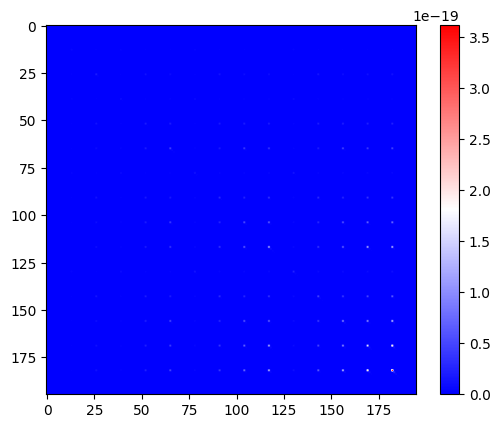

In [69]:
print(gauss_cov.shape)
plt.imshow(gauss_cov, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

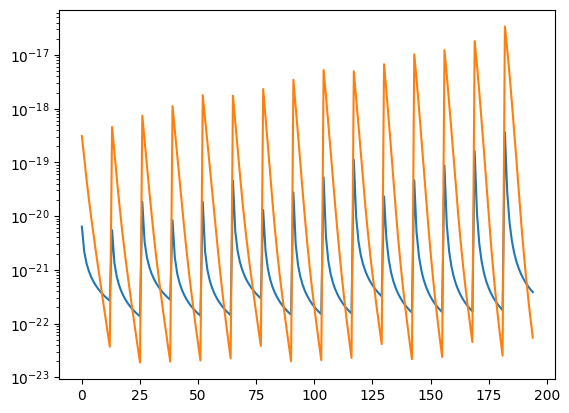

In [79]:
plt.plot(np.diag(gauss_cov))
plt.plot(np.diag(shear_cl_SRD))
plt.yscale("log")

(195, 195)


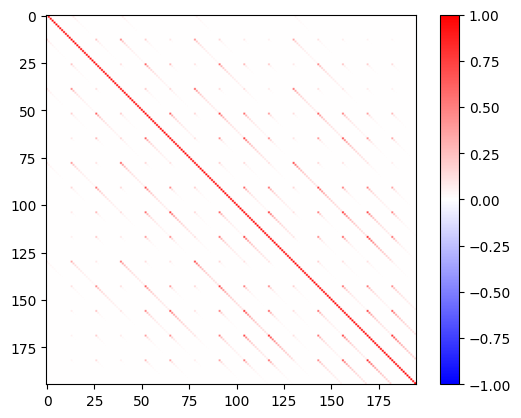

In [16]:
corr = cov2corr(gauss_cov)
print(corr.shape)
plt.imshow(corr, origin='upper', vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.show()

0.8578747116777845


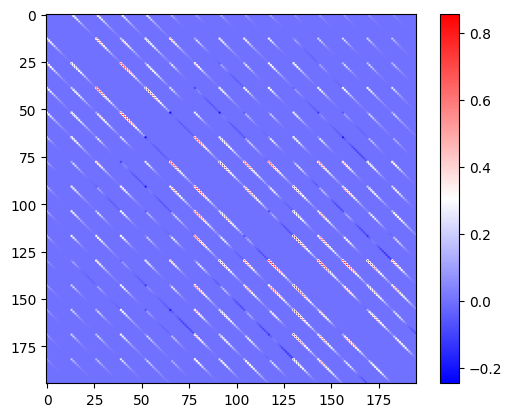

In [17]:
plt.imshow((corr_SRD - corr), origin='upper', cmap='bwr')
print(np.max(corr_SRD - corr))
plt.colorbar()
plt.show()

In [18]:
print("max difference with SRD in diagonals = ", np.max(np.abs(np.diag((shear_cl_SRD - gauss_cov))/np.diag(gauss_cov))))

max difference with SRD in diagonals =  702.5441870738754
